# Interpolated 2D scans
This example will generate an interpolated heatmap of an output after scanning over 2 parameters.

## Import packages

In [1]:
# Plotting packages
from plotnine import *
import matplotlib.pyplot as plt

# For mathematical operations
import numpy as np
import pandas as pd

# Packages for synthetic data creation
import itertools
import random
import scipy.interpolate

# For clearer visualization in the notebook (mac only)
%config InlineBackend.figure_format ='retina'

# Unit conversion parameters 
SEC_PER_DAY = 24*60*60

%load_ext autoreload
%autoreload 2

from matplotlib import colors

rng = np.random.default_rng(seed = 0)

## Creating synthetic Tscan result
As a results of using the `psf`'s Scanning functionality.

In [2]:
num_steps = 20
    
param0_scan_values = np.repeat(np.logspace(-1,2,num_steps),num_steps)
param1_scan_values = list(itertools.chain.from_iterable(itertools.repeat(np.logspace(-1,2,num_steps),num_steps)))
output_lists = [np.linspace(0,80,num_steps)+i for i in range(num_steps)]
output_list = np.concatenate(output_lists).ravel()


Tscan_param0_vs_param1 = pd.DataFrame({
    'scan_value_0' : param0_scan_values,
    'scan_value_1' : param1_scan_values,
    'value' : output_list,
    
})
Tscan_param0_vs_param1

,scan_value_0,scan_value_1,value
0,0.1,0.100000,0.000000
1,0.1,0.143845,4.210526
2,0.1,0.206914,8.421053
3,0.1,0.297635,12.631579
4,0.1,0.428133,16.842105
...,...,...,...
395,100.0,23.357215,82.157895
396,100.0,33.598183,86.368421
397,100.0,48.329302,90.578947
398,100.0,69.519280,94.789474


# Plot using `matplotlib`
- *Pros*: can use custom color map. Can do contours
- *Cons*: Need to transform scan table to get correct input shap

## Get parts for the heatmap

In [3]:
def create_heatmap_input(Tscan_df, x_col, y_col, value_col):
    """Transforms a 2D scan table into heatmap input values."""
    x, y, z = [Tscan_df[col] for col in [x_col, y_col, value_col]]
    XX, YY = np.meshgrid(x, y)
    ZZ = scipy.interpolate.griddata((x, y), z, (XX, YY), method = "cubic")
    return XX, YY, ZZ 

In [4]:
XX, YY, ZZ  = create_heatmap_input(Tscan_param0_vs_param1, "scan_value_0", "scan_value_1", "value")

## Plot heatmap

In [5]:
color_scheme = ['#FFFFE5','#FFF7BC','#FEE391','#FEC44F','#FB9A29','#EC7014','#CC4C02','#993404','#662506']

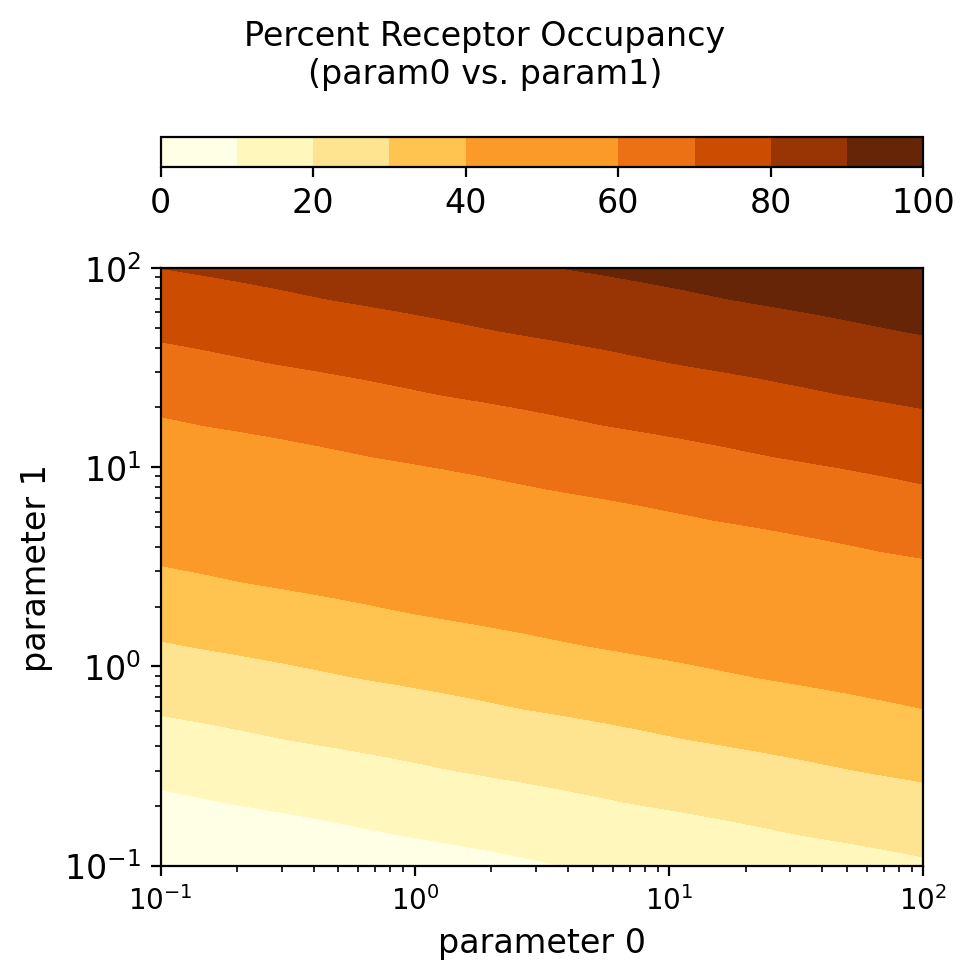

In [6]:
fig, splots = plt.subplots(figsize = (5, 5), ncols = 1, nrows = 2,
                          gridspec_kw={"height_ratios":[0.05, 1]})

ax0  = splots[1]
cax0 = splots[0]

# The main plot is a contourf
RO = ax0.contourf(XX, YY, ZZ, cmap = colors.ListedColormap(color_scheme), levels=np.arange(0,101,10))
# This is the color bar
cbar=plt.colorbar(RO, cax = cax0, orientation = "horizontal")
cbar.ax.tick_params(labelsize=12) 


ax0.set_xlabel("parameter 0", fontsize=12)
ax0.set_ylabel("parameter 1", fontsize=12)
ax0.set_yscale('log')
ax0.set_xscale('log')
plt.yticks(fontsize=12)
    
plt.suptitle('Percent Receptor Occupancy\n(param0 vs. param1)')
plt.tight_layout()

# Plot using `plotnine`

- *Pros*: no transformation of the scan table necessary.
- *Cons*: Can't do contours. Must use colored squares. Can't use custom colors

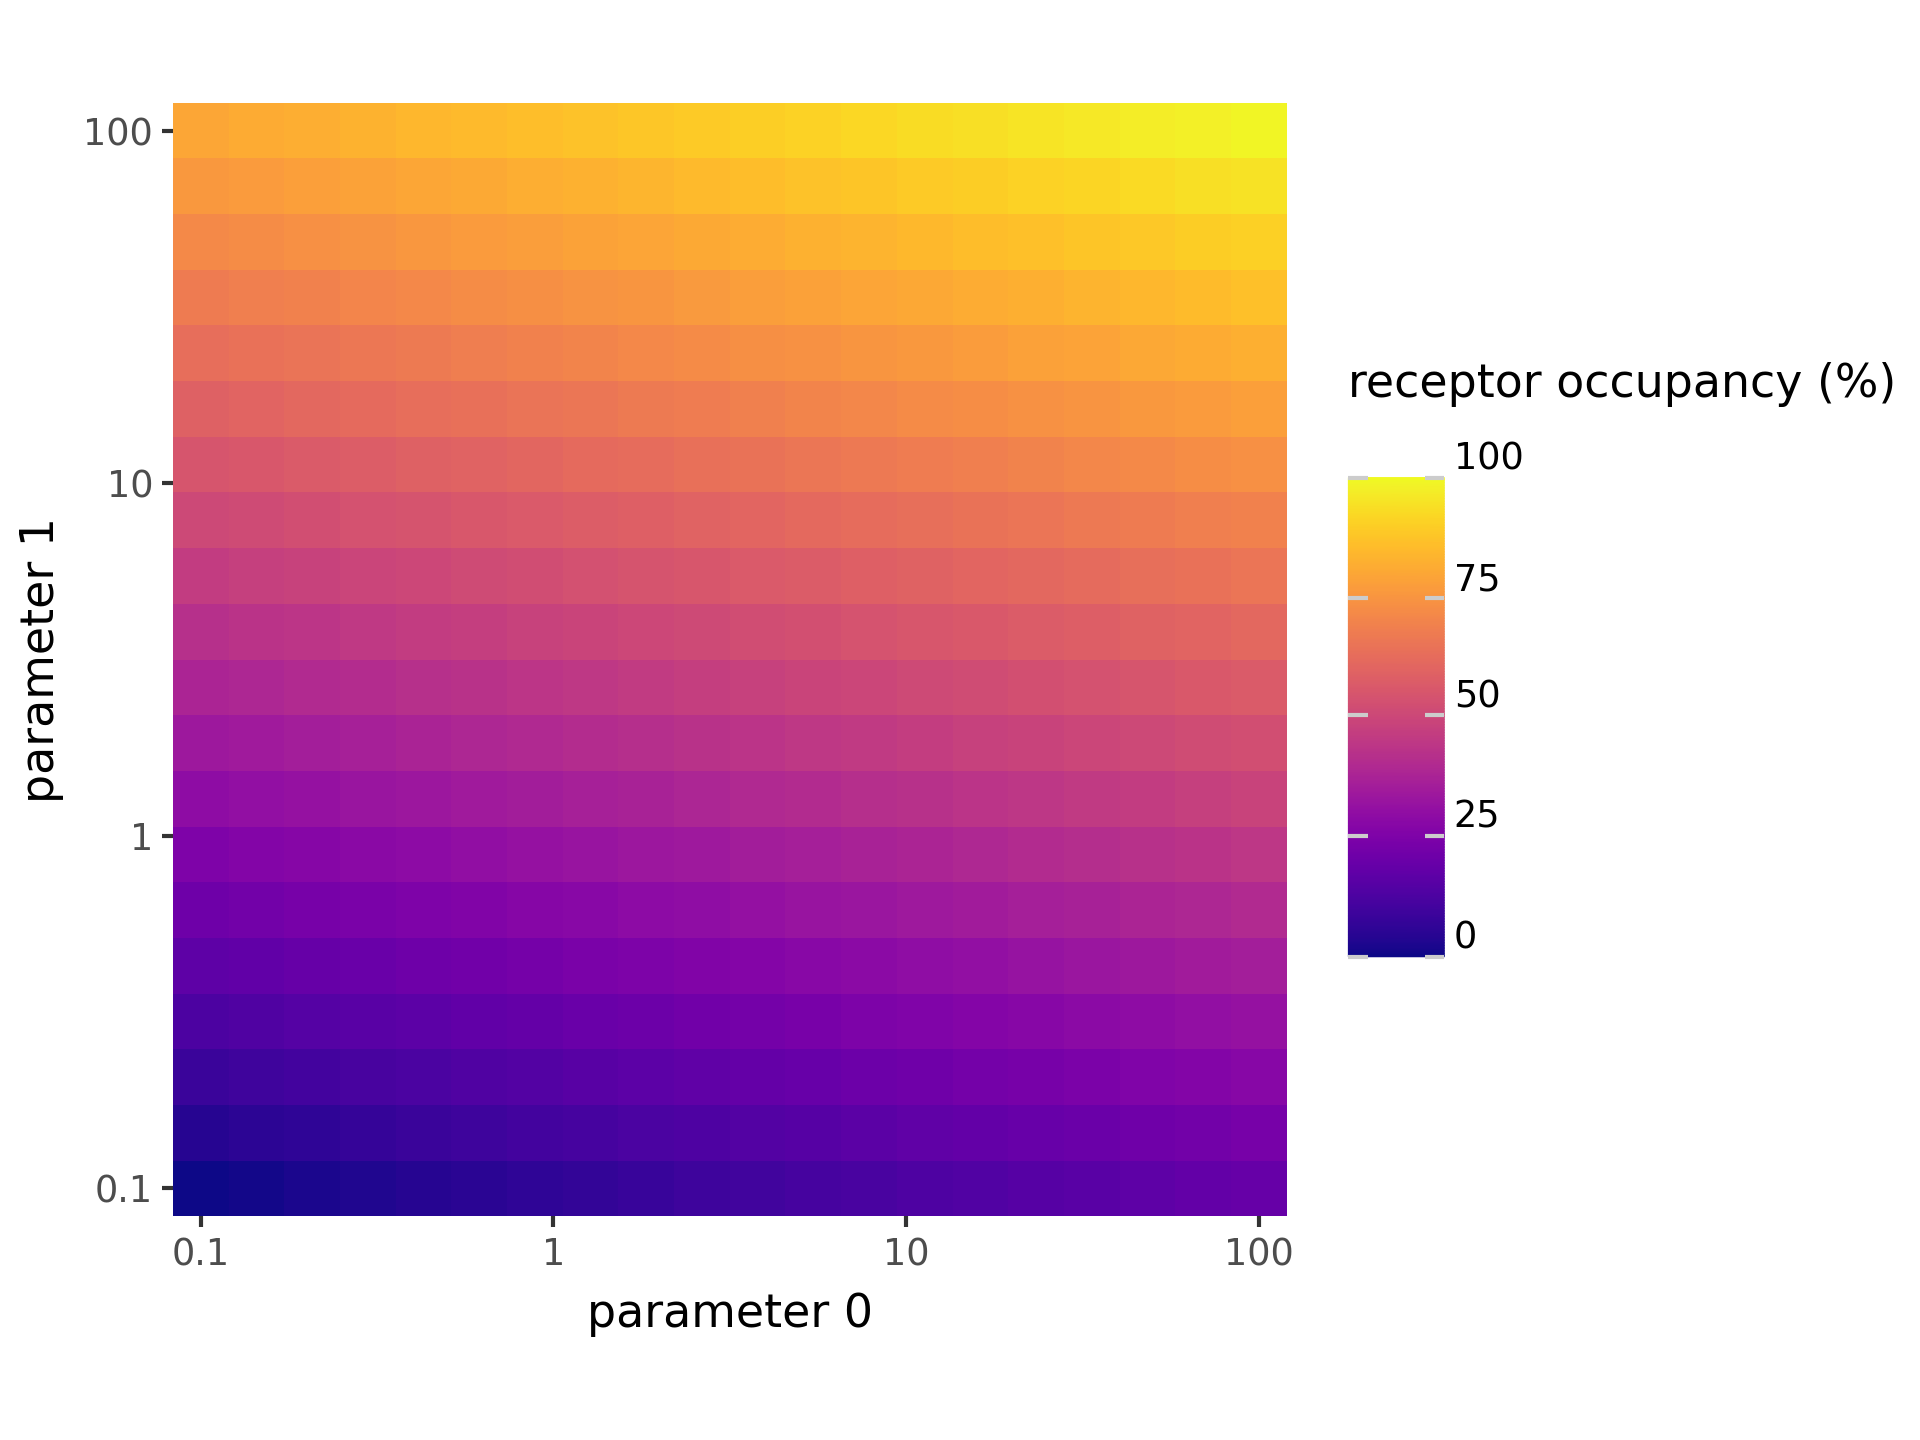

In [7]:
(
    ggplot(Tscan_param0_vs_param1, aes(x='scan_value_0', y='scan_value_1', fill='value'))
    + geom_tile()
    + scale_x_log10(expand=(0,0)) # expand=(0,0) removes gray space from edges of plot
    + scale_y_log10(expand=(0,0))
    + scale_fill_continuous(
        limits=(0,100), 
        cmap_name='plasma', 
        trans='identity' # set trans='log10' for log-scaled colors. Don't forget to set limits > 0!
    ) 
    + labs(x = 'parameter 0', y = 'parameter 1', fill = 'receptor occupancy (%)')
    + theme(
        aspect_ratio = 1,
        dpi = 150,
        legend_text_colorbar = element_text(va = 'bottom'), # This puts the color numbers closer to the ticks
        legend_title=element_text(margin={'b':8}) # This moves the color title further from the color bar
    ) 
)